In [318]:
import re
import pandas as pd
import os
import sklearn
import pickle
import seaborn as sns
import numpy as np
import sys
sys.path.append("/Users/jiahang/Documents/dagma/src/dagma/")
import utils
import matplotlib.pyplot as plt
import utils_dagma
import networkx as nx
import scipy

def load_data_46(n_nodes, s0, seed, option=10, norm=""):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v46/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS{norm}/W/W_{seed}_1_0.pkl'), 'rb') as f:
        W = pickle.load(f)
    with open(os.path.join(root_path, f'v46/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS/X/X_{seed}.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    with open(os.path.join(root_path, f'v46/v{n_nodes}_{n_nodes * s0}_option_{option}_OLS/knockoff/knockoff_{seed}_1.pkl'), 'rb') as f:
        X_tilde = pickle.load(f)
    
    return W['W_est'], W_true, B_true, X, X_tilde

def load_true_11(n_nodes, s0):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v11/v{n_nodes}_{n_nodes * s0}/X/X_1.pkl'), 'rb') as f:
        X = pickle.load(f)
    W_true = X['W_true']
    X = X['X']
    B_true = (W_true != 0)
    
    return W_true, B_true, X

def load_data_39(n_nodes, s0, seed):
    root_path="/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
    with open(os.path.join(root_path, f'v39/W_{n_nodes}_{n_nodes * s0}_{seed}.pkl'), 'rb') as f:
        W = pickle.load(f)
    return W

def get_block(data, n_nodes=20, index=11):
    data_dict = {
        11: data[:n_nodes, :n_nodes],
        12: data[:n_nodes, n_nodes:],
        21: data[n_nodes:, :n_nodes],
        22: data[n_nodes:, n_nodes:]
    }
    
    return data_dict[index]

def sys_z0_vs_deg_box(n_nodes, version_path, notes, seed=1, alpha=0.5, use_strip=True, remove_self_loop=False):
    n_nodes = n_nodes
    X, B_true, W_est, W_true = load_data(n_nodes, seed, f"{version_path}")
    real_p = W_est.shape[0]
    if remove_self_loop:
        W_est[np.eye(real_p, real_p).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=real_p // 2).astype(bool)] = 0.
        W_est[np.eye(real_p, real_p, k=-real_p // 2).astype(bool)] = 0.
    W11, W21 = get_block(W_est, n_nodes=n_nodes, index=11), get_block(W_est, n_nodes=n_nodes, index=21)
    Z11_21 = get_Z(W_est, n_nodes=n_nodes)

    out_deg = B_true.sum(axis=1)
    in_deg = B_true.sum(axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    df = z0_vs_deg_box(Z11_21, B_true, out_deg, in_deg, ax, src=True, use_out_deg=False, use_strip=use_strip, alpha=alpha, notes=notes)
    return df

def get_res(filename):
    pattern = r"est fdr (\d+\.\d+) \| true fdr (\d+\.\d+) \| true power (\d+\.\d+)"
    
    logs = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        for line in lines:  # choose the first line - 1 : the last line
            match = re.search(pattern, line)
            if match:
                groups = match.groups()
                groups = [float(i) for i in groups]
                logs.append(groups)
    df = pd.DataFrame(logs, columns=["est fdr", "true fdr", "true power"])
    return df

def fdr_log(W, W_true):
    W11, W21 = \
        get_block(W, n_nodes=W.shape[1] // 2, index=11), \
        get_block(W, n_nodes=W.shape[1] // 2, index=21)
    
    Z = np.abs(W11) - np.abs(W21)
    fdr = 0.2
    t_list = np.concatenate(([0], np.sort(np.unique(np.abs(Z)))))
    t_last = np.inf
    fdr_est_last = None
    T_T_true = np.abs(W_true)
    mask = (T_T_true > 0.)
    T_T_true[mask], T_T_true[~mask] = 1, 0
    
    for t in reversed(t_list):
        if t < 0.:
            break
        
        fdr_est = (1 + (Z <= -t).sum()) / np.max((1, (Z >= t).sum()))
        
        T_T = Z.copy()
        mask = (T_T >= t)
        T_T[mask], T_T[~mask] = 1, 0
        perf = utils_dagma.count_accuracy_simplify(T_T_true, T_T)
        fdr_true, power = perf['fdr'], perf['tpr']
    
        print(f"thresh {t:.4f} | est fdr {fdr_est:.4f} | true fdr {fdr_true:.4f} | true power {power:.4f}")
    
        if fdr_est <= fdr:
            t_last = t
            fdr_est_last = fdr_est

def topo_depth(B_true):
    G = nx.DiGraph(B_true)
    topo_depth = 0
    in_deg = B_true.sum(axis=0)
    vis_n = np.zeros_like(in_deg)
    while not (in_deg == 0.).all():
        no_in_deg_nodes = np.where((in_deg == 0) & (vis_n != 1))[0]
        for n in no_in_deg_nodes:
            successors = list(G.successors(n))
            in_deg[successors] -= 1
            assert (in_deg >= 0).all()
        vis_n[no_in_deg_nodes] = 1
        topo_depth += 1
    return topo_depth

In [319]:
"""exp design (ALL DONE)
1. condition number distributions of X
2. find those X with normal condition number, as X_normal
3. test fdr control results / Z distribution results of X_normal

works! observations
1) (figure 1) with the increase of cond, uncontrollable cases become more while controllable cases become less
2) (figure 2) with the increase of cond, fdr becomes more and more difficult to control (true fdr goes up). The first 70% seeds can be controlled. 
3) (figure 3) similar to 2). however, 40:50 also uncontrollable. Note that there are 10 seeds, and this cond is a 
middle cond, which is more offen to be sampled if cond is normal distribution. weird.

If 3. above controls fdr, go below some directions
* (DONE) fdr control results / Z distribution shift over all 100 seeds, and see patterns. e.g. all non ill-condition X have good 
    fdr control, and all ill-condition X have bad fdr control. These patterns will better support our core hypothesis:
    ill-condition X is the cause of bad fdr control / Z distribution shift.

* (DONE) is fdr control more lated X scale? Note that ill-condition of X can be caused by 1) X scale. 2) X collinearity. However, the same nodes + edges should have too different collinearity, thus the 
condition number resulted from collinearity should be similar.
* (unimportant) Yes! the ill-condition can be said completely resulted from large scale X! why such X happens?

* find a method to reduce the ill-condition of X, such as normalization.
* it's hard to tell layer and batch norm which is better. try both.

* hypothesis 1: the probability of being ill-condition X increase with larger-scale graphs (not important)
"""

"exp design (ALL DONE)\n1. condition number distributions of X\n2. find those X with normal condition number, as X_normal\n3. test fdr control results / Z distribution results of X_normal\n\nworks! observations\n1) (figure 1) with the increase of cond, uncontrollable cases become more while controllable cases become less\n2) (figure 2) with the increase of cond, fdr becomes more and more difficult to control (true fdr goes up). The first 70% seeds can be controlled. \n3) (figure 3) similar to 2). however, 40:50 also uncontrollable. Note that there are 10 seeds, and this cond is a \nmiddle cond, which is more offen to be sampled if cond is normal distribution. weird.\n\nIf 3. above controls fdr, go below some directions\n* (DONE) fdr control results / Z distribution shift over all 100 seeds, and see patterns. e.g. all non ill-condition X have good \n    fdr control, and all ill-condition X have bad fdr control. These patterns will better support our core hypothesis:\n    ill-condition X

# check cases with large condition number but 0 fdr and 0 power
These cases could be 1) est fdr > true fdr > 0.2, 2) true fdr > est fdr > 0.2. Only 2) is acceptable.

In [127]:
"""
seed=2, True
"""
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 1+1, option=5)
fdr_log(W, W_true)

thresh 2.1275 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0000
thresh 1.9643 | est fdr 3.0000 | true fdr 0.0000 | true power 0.0000
thresh 1.8112 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0000
thresh 1.7280 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0028
thresh 1.5557 | est fdr 5.0000 | true fdr 0.0000 | true power 0.0028
thresh 1.4737 | est fdr 6.0000 | true fdr 0.0000 | true power 0.0028
thresh 1.4617 | est fdr 3.0000 | true fdr 0.0000 | true power 0.0056
thresh 1.4441 | est fdr 3.5000 | true fdr 0.0000 | true power 0.0056
thresh 1.3580 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0056
thresh 1.3344 | est fdr 4.5000 | true fdr 0.0000 | true power 0.0056
thresh 1.3104 | est fdr 3.0000 | true fdr 0.0000 | true power 0.0083
thresh 1.3081 | est fdr 3.3333 | true fdr 0.0000 | true power 0.0083
thresh 1.2922 | est fdr 3.6667 | true fdr 0.0000 | true power 0.0083
thresh 1.2847 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0083
thresh 1.2674 | est fdr 3.0000 | t

In [124]:
"""
seed=18, True
"""
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 17+1, option=5)
fdr_log(W, W_true)

thresh 1.7938 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0028
thresh 1.6330 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0056
thresh 1.5444 | est fdr 0.3333 | true fdr 0.0000 | true power 0.0083
thresh 1.4286 | est fdr 0.6667 | true fdr 0.0000 | true power 0.0083
thresh 1.3381 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0111
thresh 1.2401 | est fdr 0.4000 | true fdr 0.0000 | true power 0.0139
thresh 1.2376 | est fdr 0.6000 | true fdr 0.0000 | true power 0.0139
thresh 1.2037 | est fdr 0.8000 | true fdr 0.0000 | true power 0.0139
thresh 1.1899 | est fdr 0.6667 | true fdr 0.0000 | true power 0.0167
thresh 1.1837 | est fdr 0.5714 | true fdr 0.0000 | true power 0.0194
thresh 1.1821 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0222
thresh 1.1533 | est fdr 0.4444 | true fdr 0.0000 | true power 0.0250
thresh 1.1053 | est fdr 0.5556 | true fdr 0.0000 | true power 0.0250
thresh 1.0942 | est fdr 0.5000 | true fdr 0.1000 | true power 0.0250
thresh 1.0873 | est fdr 0.4545 | t

In [122]:
"""
seed=26, True
"""
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 25+1, option=5)
fdr_log(W, W_true)

thresh 1.7820 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0028
thresh 1.7339 | est fdr 0.5000 | true fdr 0.0000 | true power 0.0056
thresh 1.6816 | est fdr 0.3333 | true fdr 0.0000 | true power 0.0083
thresh 1.6373 | est fdr 0.2500 | true fdr 0.0000 | true power 0.0111
thresh 1.6214 | est fdr 0.2000 | true fdr 0.0000 | true power 0.0139
thresh 1.6212 | est fdr 0.1667 | true fdr 0.0000 | true power 0.0167
thresh 1.6182 | est fdr 0.1429 | true fdr 0.0000 | true power 0.0194
thresh 1.4794 | est fdr 0.1250 | true fdr 0.0000 | true power 0.0222
thresh 1.4039 | est fdr 0.1111 | true fdr 0.0000 | true power 0.0250
thresh 1.3419 | est fdr 0.2222 | true fdr 0.0000 | true power 0.0250
thresh 1.1416 | est fdr 0.2000 | true fdr 0.0000 | true power 0.0278
thresh 1.1375 | est fdr 0.1818 | true fdr 0.0000 | true power 0.0306
thresh 1.1089 | est fdr 0.2727 | true fdr 0.0000 | true power 0.0306
thresh 1.0736 | est fdr 0.3636 | true fdr 0.0000 | true power 0.0306
thresh 1.0222 | est fdr 0.3333 | t

In [128]:
"""
seed=86, True
"""
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 85+1, option=5)
fdr_log(W, W_true)

thresh 1.6500 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.3623 | est fdr 2.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.3010 | est fdr 3.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.2910 | est fdr 4.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.1676 | est fdr 2.0000 | true fdr 0.5000 | true power 0.0028
thresh 1.1119 | est fdr 2.5000 | true fdr 0.5000 | true power 0.0028
thresh 1.0568 | est fdr 1.6667 | true fdr 0.6667 | true power 0.0028
thresh 1.0023 | est fdr 2.0000 | true fdr 0.6667 | true power 0.0028
thresh 0.9712 | est fdr 1.5000 | true fdr 0.5000 | true power 0.0056
thresh 0.9603 | est fdr 1.2000 | true fdr 0.6000 | true power 0.0056
thresh 0.9423 | est fdr 1.4000 | true fdr 0.6000 | true power 0.0056
thresh 0.9336 | est fdr 1.1667 | true fdr 0.5000 | true power 0.0083
thresh 0.8538 | est fdr 1.0000 | true fdr 0.4286 | true power 0.0111
thresh 0.8318 | est fdr 0.8750 | true fdr 0.3750 | true power 0.0139
thresh 0.7962 | est fdr 0.7778 | t

In [305]:
# [86, 85, 52, 40, 18, 26, 74, 63, 2, 1]
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 2, option=5, norm='_col')
fdr_log(W, W_true)

thresh 2.7647 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.5722 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 1.5559 | est fdr 0.3333 | true fdr 1.0000 | true power 0.0000
thresh 1.2185 | est fdr 0.6667 | true fdr 1.0000 | true power 0.0000
thresh 1.1855 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 1.1673 | est fdr 0.4000 | true fdr 1.0000 | true power 0.0000
thresh 1.1661 | est fdr 0.3333 | true fdr 1.0000 | true power 0.0000
thresh 1.1339 | est fdr 0.2857 | true fdr 1.0000 | true power 0.0000
thresh 1.1001 | est fdr 0.2500 | true fdr 1.0000 | true power 0.0000
thresh 0.9370 | est fdr 0.2222 | true fdr 1.0000 | true power 0.0000
thresh 0.9133 | est fdr 0.2000 | true fdr 1.0000 | true power 0.0000
thresh 0.8920 | est fdr 0.3000 | true fdr 1.0000 | true power 0.0000
thresh 0.8689 | est fdr 0.2727 | true fdr 1.0000 | true power 0.0000
thresh 0.8537 | est fdr 0.2500 | true fdr 1.0000 | true power 0.0000
thresh 0.8444 | est fdr 0.2308 | t

In [301]:
# [86, 85, 52, 40, 18, 26, 74, 63, 2, 1]
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 86, option=5, norm='_row')
fdr_log(W, W_true)

thresh 0.5082 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0000
thresh 0.4333 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0028
thresh 0.4274 | est fdr 3.0000 | true fdr 0.0000 | true power 0.0028
thresh 0.3906 | est fdr 4.0000 | true fdr 0.0000 | true power 0.0028
thresh 0.3649 | est fdr 5.0000 | true fdr 0.0000 | true power 0.0028
thresh 0.3576 | est fdr 2.5000 | true fdr 0.0000 | true power 0.0056
thresh 0.3399 | est fdr 1.6667 | true fdr 0.0000 | true power 0.0083
thresh 0.3370 | est fdr 2.0000 | true fdr 0.0000 | true power 0.0083
thresh 0.3240 | est fdr 1.5000 | true fdr 0.0000 | true power 0.0111
thresh 0.3176 | est fdr 1.2000 | true fdr 0.0000 | true power 0.0139
thresh 0.3113 | est fdr 1.0000 | true fdr 0.0000 | true power 0.0167
thresh 0.3090 | est fdr 0.8571 | true fdr 0.0000 | true power 0.0194
thresh 0.3026 | est fdr 0.7500 | true fdr 0.0000 | true power 0.0222
thresh 0.3021 | est fdr 0.8750 | true fdr 0.0000 | true power 0.0222
thresh 0.2993 | est fdr 1.0000 | t

In [313]:
# [86, 85, 52, 40, 18, 26, 74, 63, 2, 1]
W, W_true, B_true, X, X_tilde = load_data_46(60, 6, 1, option=5, norm='_col')
fdr_log(W, W_true)

thresh 1.8804 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.7748 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 1.2950 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 1.2129 | est fdr 0.6667 | true fdr 1.0000 | true power 0.0000
thresh 1.0541 | est fdr 0.5000 | true fdr 1.0000 | true power 0.0000
thresh 1.0428 | est fdr 0.7500 | true fdr 1.0000 | true power 0.0000
thresh 0.9924 | est fdr 1.0000 | true fdr 1.0000 | true power 0.0000
thresh 0.9480 | est fdr 0.8000 | true fdr 1.0000 | true power 0.0000
thresh 0.8473 | est fdr 0.6667 | true fdr 1.0000 | true power 0.0000
thresh 0.8400 | est fdr 0.5714 | true fdr 1.0000 | true power 0.0000
thresh 0.8334 | est fdr 0.7143 | true fdr 1.0000 | true power 0.0000
thresh 0.8224 | est fdr 0.6250 | true fdr 1.0000 | true power 0.0000
thresh 0.7760 | est fdr 0.7500 | true fdr 1.0000 | true power 0.0000
thresh 0.7509 | est fdr 0.6667 | true fdr 1.0000 | true power 0.0000
thresh 0.7434 | est fdr 0.6000 | t

In [314]:
X.max()

200676.91392098798

# true fdr vs condition number

In [315]:
from tqdm import tqdm
file_dir = "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/v11/v60_360/X/"
Xs = []
filenames = os.listdir(file_dir)

def extract_t(filename):
    return int(re.search(r'\d+', filename).group())
filenames = [filename for filename in filenames if ".pkl" in filename]
filenames = sorted(filenames, key=extract_t)

for name in filenames:
    with open(os.path.join(file_dir, name), 'rb') as f:
        X = pickle.load(f)['X']
    Xs.append(X)
X_all = np.stack(Xs)
conds = np.linalg.cond(X_all)

In [329]:
X_all[0].T.shape

(60, 2000)

In [146]:
topo_depths = []
for seed in range(1, 101):
    W, W_true, B_true, X, X_tilde = load_data_46(60, 6, seed, option=5)
    topo_depths.append(topo_depth(B_true))

In [335]:
min_singulars = []
for seed in range(1, 101):
    W, W_true, B_true, X, X_tilde = load_data_46(60, 6, seed, option=5)
    min_singulars.append(scipy.linalg.svdvals(X).min())

In [344]:
max_singulars = []
for seed in range(1, 101):
    W, W_true, B_true, X, X_tilde = load_data_46(60, 6, seed, option=5)
    max_singulars.append(scipy.linalg.svdvals(X).max())

In [346]:
df = get_res("/Users/jiahang/Documents/dagma/src/dagma/notebooks/log_46_60_360_option_5_OLS.brief")
df['control'] = (df['true fdr'] <= 0.2)
df['cond'] = conds
df['topo_depth'] = topo_depths
df['topo_depth * cond'] = df['cond'] * df['topo_depth']
df['topo_depth * log(cond)'] = np.log(df['cond']) * df['topo_depth']
df['min_sing'] = min_singulars
df['max_sing'] = max_singulars

<Axes: ylabel='cond'>

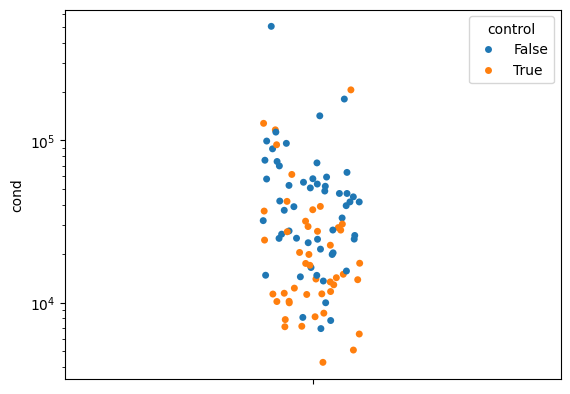

In [130]:
sns.stripplot(data=df, y='cond', hue='control', log_scale=True)

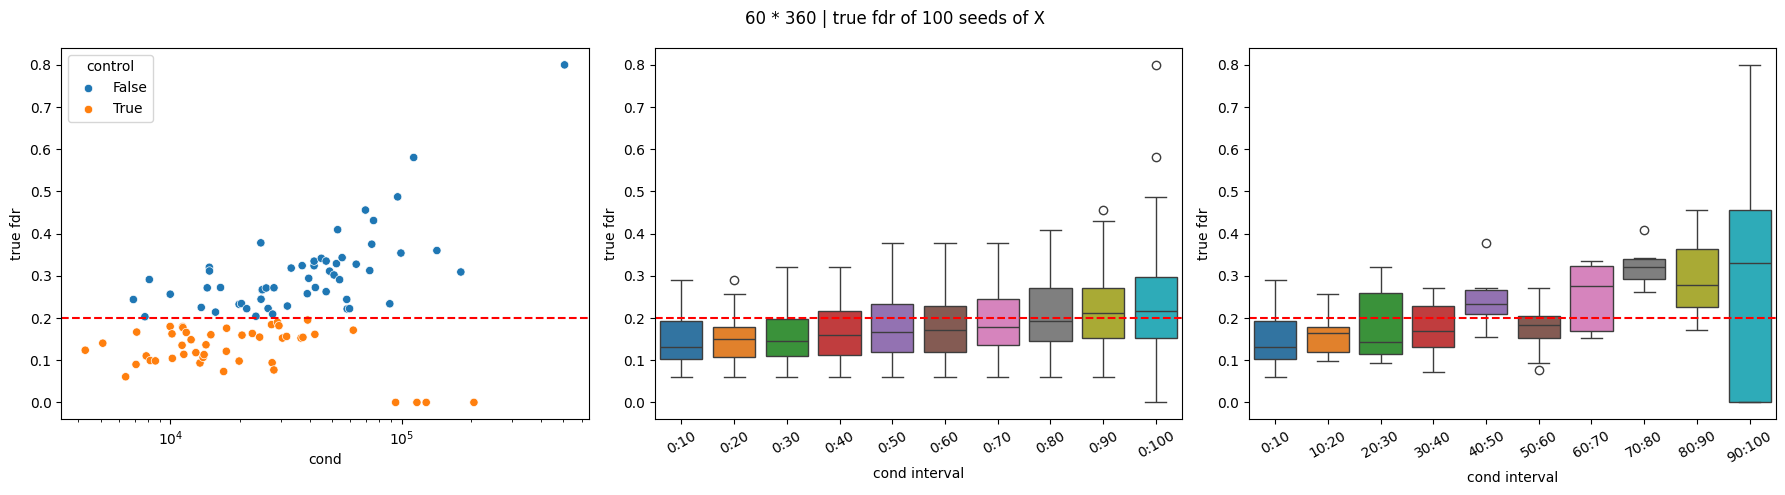

In [308]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

ax = axs[0]
sns.scatterplot(data=df.sort_values('cond'), y='true fdr', x='cond', hue='control', ax=ax)
ax.set(xscale='log')
ax.axhline(y=0.2, color='r', linestyle='--')

ax = axs[1]
res_list = []
for percent in range(10, 101, 10):
    res_list.append(df.sort_values('cond')[:percent]['true fdr'].values)
sns.boxplot(res_list, ax=ax)
ax.axhline(y=0.2, color='r', linestyle='--')
ax.set_xlabel("cond interval")
ax.set_xticks(ticks=range(10), labels=[f"0:{i * 10}" for i in range(1, 11)], rotation=30)
ax.set_ylabel("true fdr")

ax = axs[2]
res_list = []
for percent in range(0, 91, 10):
    res_list.append(df.sort_values('cond')[percent:percent+10]['true fdr'].values)
sns.boxplot(res_list, ax=ax)
ax.axhline(y=0.2, color='r', linestyle='--')
ax.set_xlabel("cond interval")
ax.set_xticks(ticks=range(10), labels=[f"{i * 10}:{(i+1) * 10}" for i in range(10)], rotation=30)
ax.set_ylabel("true fdr")

plt.suptitle("60 * 360 | true fdr of 100 seeds of X")
plt.tight_layout()

In [337]:
df

,est fdr,true fdr,true power,control,cond,topo_depth,topo_depth * cond,topo_depth * log(cond),min_sing
0,0.2000,0.8000,0.0056,False,505973.563738,21,1.062544e+07,275.819034,6.139853
1,1.0000,0.0000,0.0000,True,205217.408980,20,4.104348e+06,244.636505,5.705249
2,0.2000,0.1773,0.5028,True,11315.615625,14,1.584186e+05,130.675146,5.652672
3,0.1970,0.1212,0.4833,True,17438.718739,19,3.313357e+05,185.562516,5.662410
4,0.1975,0.2716,0.3278,False,14418.490886,18,2.595328e+05,172.372802,5.581843
...,...,...,...,...,...,...,...,...,...
95,0.2000,0.2565,0.4750,False,9976.057312,17,1.695930e+05,156.535035,5.815853
96,0.1978,0.0934,0.4583,True,13412.914860,18,2.414325e+05,171.071520,5.363874
97,0.1992,0.2712,0.4778,False,25944.749642,17,4.410607e+05,172.783317,5.799496
98,0.1978,0.1758,0.4167,True,17488.469020,14,2.448386e+05,136.770158,6.011544


Text(0.5, 0.98, '60 * 360 | true fdr of 100 seeds of X')

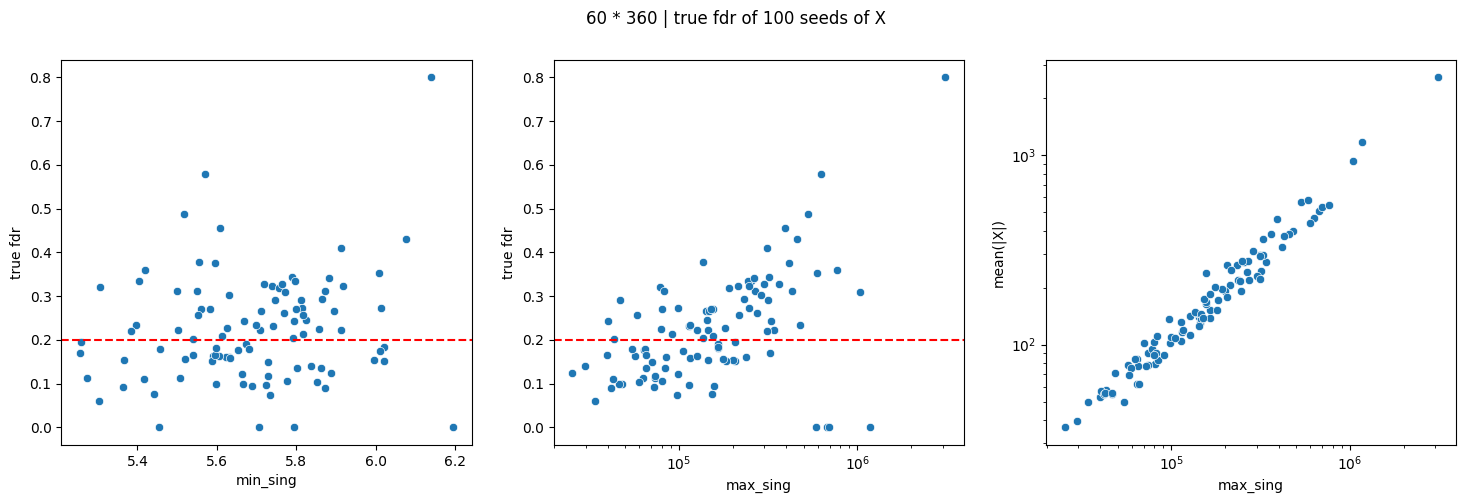

In [353]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

ax = axs[0]
sns.scatterplot(df, y='true fdr', x='min_sing', ax=ax)
ax.axhline(y=0.2, color='r', linestyle='--')

ax = axs[1]
sns.scatterplot(df, y='true fdr', x='max_sing', ax=ax)
ax.axhline(y=0.2, color='r', linestyle='--')
ax.set(xscale='log')

ax = axs[2]
sns.scatterplot(df, y='mean(|X|)', x='max_sing', ax=ax)
# ax.axhline(y=0.2, color='r', linestyle='--')
ax.set(xscale='log', yscale='log')

plt.suptitle("60 * 360 | true fdr of 100 seeds of X")

In [263]:
df.sort_values('cond')[-10:].index+1

Index([86, 85, 52, 40, 18, 26, 74, 63, 2, 1], dtype='int64')

In [281]:
df.sort_values('cond')

,est fdr,true fdr,true power,control,cond,topo_depth,topo_depth * log(cond),topo_depth * cond,mean(|X|),max(|X|),mean(X),max(X),std(X)
63,0.1989,0.1237,0.4528,True,4279.193843,15,125.422799,6.418791e+04,36.455813,1662.062736,-0.007432,1662.062736,89.003783
50,0.1988,0.1404,0.4083,True,5095.391869,15,128.041378,7.643088e+04,39.518092,1255.526081,0.064066,1174.485061,92.597446
29,0.1959,0.0608,0.3861,True,6398.804470,13,113.930264,8.318446e+04,49.681069,1617.808993,0.776039,1617.808993,109.213896
36,0.1951,0.2439,0.3444,False,6910.823565,16,141.453506,1.105732e+05,57.171702,2192.039133,-0.645278,2192.039133,142.149406
75,0.2000,0.0900,0.5056,True,7095.256985,13,115.273364,9.223834e+04,55.094586,3394.207427,-0.384093,2524.098218,135.317399
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.1818,0.0000,0.0306,True,127594.821648,20,235.132301,2.551896e+06,534.762762,42631.500069,-2.881763,42631.500069,2011.178724
73,0.2000,0.3600,0.0444,False,141930.325852,18,213.535648,2.554746e+06,547.061296,47186.870929,3.495509,47186.870929,2223.201374
62,0.2000,0.3091,0.1056,False,180143.143253,20,242.030141,3.602863e+06,935.140123,61837.072800,-11.627746,61837.072800,3001.656601
1,1.0000,0.0000,0.0000,True,205217.408980,20,244.636505,4.104348e+06,1175.699895,43831.716028,0.256239,39918.922144,3381.446156


# true fdr vs X scale
* seems that true_fdr vs X scale is similar to true_fdr vs condition number. Is X scale related to condition number?

In [351]:
df['mean(|X|)'] = [np.abs(_X).mean() for _X in X_all]
df['max(|X|)'] = [np.abs(_X).max() for _X in X_all]

df['mean(X)'] = [_X.mean() for _X in X_all]
df['std(X)'] = [_X.std() for _X in X_all]
df['max(X)'] = [_X.max() for _X in X_all]

[None]

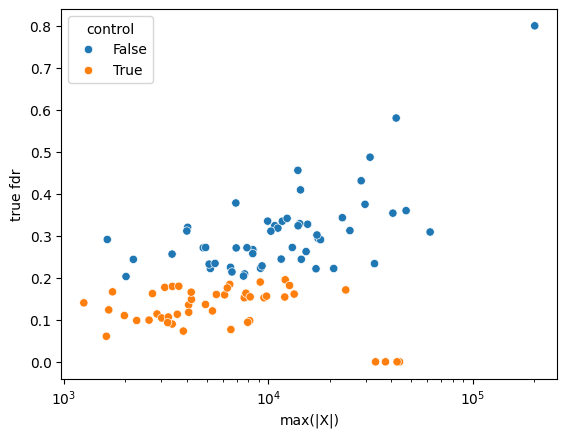

In [234]:
ax = sns.scatterplot(data=df, y='true fdr', x='max(|X|)', hue='control')
ax.set(xscale='log')

# X scale vs condition number
YES! The X scale and conditon number is STRICTLY linearly positively related! We can say the condition number results from large X scale.

We can normalize X to help reduce the condition number!

Text(0.5, 0.98, '60 * 360 | condition number of X vs scale of |X|')

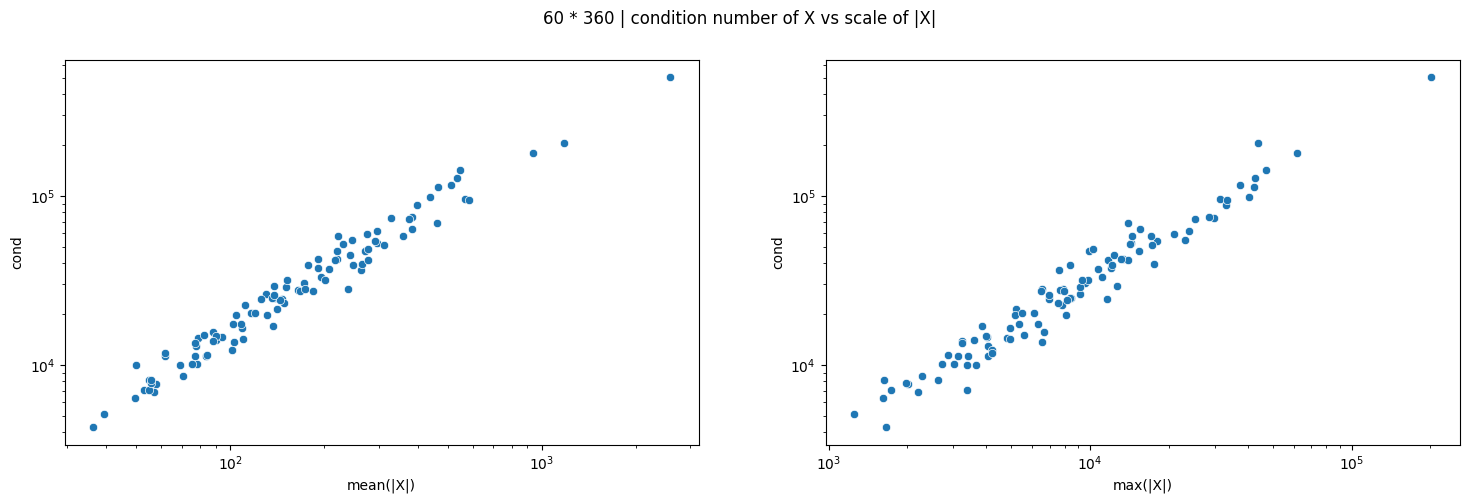

In [304]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

ax = axs[0]
sns.scatterplot(data=df, y='cond', x='mean(|X|)', ax=ax)
ax.set(yscale='log', xscale='log')

ax = axs[1]
sns.scatterplot(data=df, y='cond', x='max(|X|)', ax=ax)
ax.set(yscale='log', xscale='log')

plt.suptitle("60 * 360 | condition number of X vs scale of |X|")

[None, None]

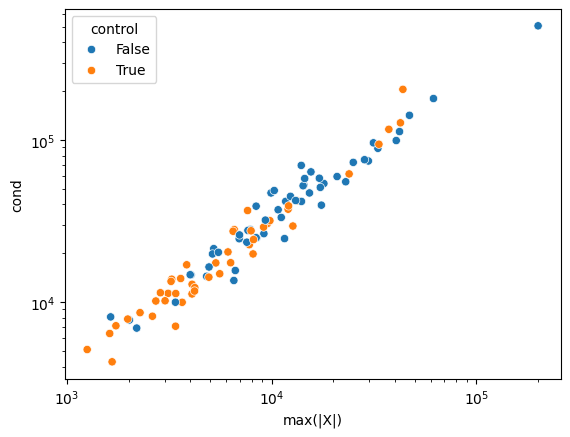

In [240]:
ax = sns.scatterplot(data=df, y='cond', x='max(|X|)')
ax.set(yscale='log', xscale='log')

[None]

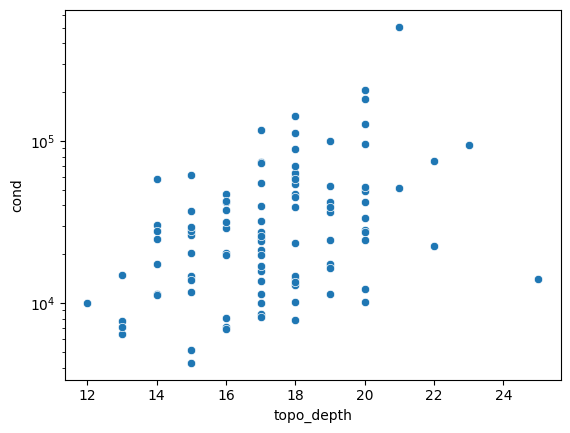

In [309]:
ax = sns.scatterplot(data=df, y='cond', x='topo_depth')
ax.set(yscale='log')

[None]

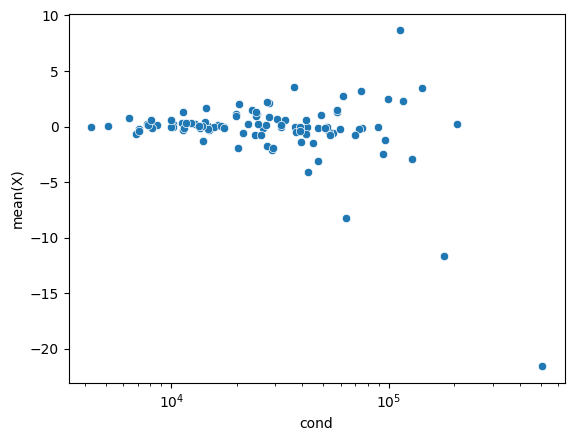

In [253]:
ax = sns.scatterplot(data=df, y='mean(X)', x='cond')
ax.set(xscale='log')

[None, None]

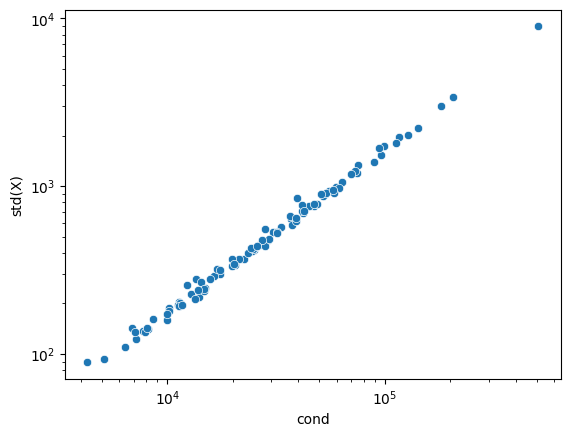

In [255]:
ax = sns.scatterplot(data=df, y='std(X)', x='cond')
ax.set(xscale='log', yscale='log')

[None]

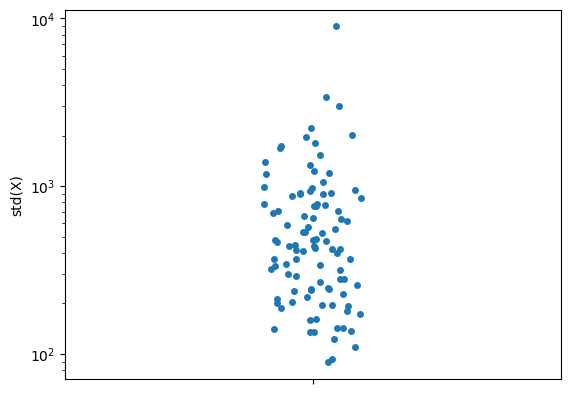

In [257]:
ax = sns.stripplot(df['std(X)'])
ax.set(yscale='log')

In [268]:
X_tildes = []
root_path = "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
for seed in df.sort_values('cond')[-10:].index+1:
    with open(os.path.join(root_path, f'v46/v60_360_option_5_OLS_col/knockoff/knockoff_{seed}_1.pkl'), 'rb') as f:
        X_tilde = pickle.load(f)
    X_tildes.append(X_tilde.flatten())
X_tilde = np.stack(X_tildes)

<Axes: >

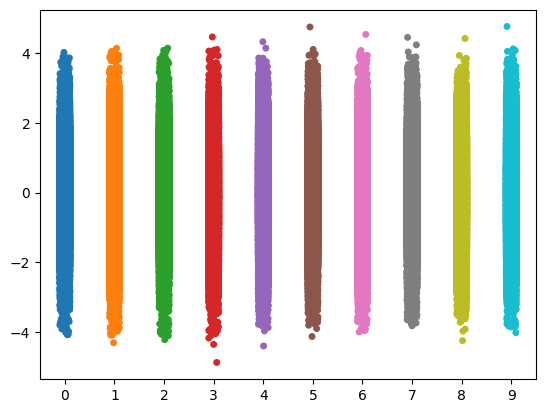

In [273]:
sns.stripplot(X_tilde.T)

<Axes: >

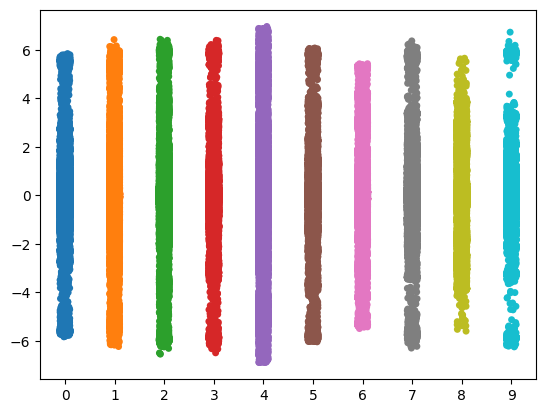

In [278]:
X_tildes = []
root_path = "/Users/jiahang/Documents/dagma/src/dagma/simulated_data/"
for seed in df.sort_values('cond')[-10:].index+1:
    with open(os.path.join(root_path, f'v46/v60_360_option_5_OLS_row/knockoff/knockoff_{seed}_1.pkl'), 'rb') as f:
        X_tilde = pickle.load(f)
    X_tildes.append(X_tilde.flatten())
X_tilde = np.stack(X_tildes)
sns.stripplot(X_tilde.T)

In [277]:
X.mean(1, keepdims=True).shape

(2000, 1)